# Read, analyse and plot data with Python 2.x!

This is a very short script to plot SST from a 1/4 deg. NEMO simulation. 

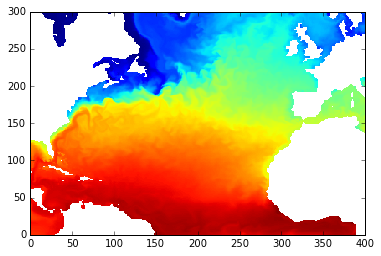

In [3]:
## simplest plot
import matplotlib   ## make plots appear in this document and not in a separate window
%matplotlib inline  
import matplotlib.pyplot as plt ## load plot module
from netCDF4 import Dataset  ## load netCDF module
nc = Dataset('/Users/joakim/Downloads/means/2000/ORCA025-N401_20000105d05T.nc','r') ## open netCDF file
plt.pcolormesh(nc.variables['votemper'][0,0,500:800,800:1200]) ## read and plot N Atl SST
plt.show() ## show fig

Here's the line-by-line of what just happened. 

* Line 1: Anything after hash # is considered a comment
* Line 2: Load matplotlib plotting tools. 
* Line 3: Make sure all plots are "inlined", i.e. appear in this notebook and not in a separate window. 
* Line 4: We load the plotting tools. "plt" is an object that holds ALL the plotting tools. 
* Line 5: We load the netCDF4 library, but only the "Dataset" object, which is the one we need to read or create files. 
* Line 6: Give Dataset the file path and the opening mode, "r" means "read-only". "c" would create, "w" would write.  "nc" is now an object that holds everything about the file, as well as all functions from "Dataset" that are meant for read-only files. 
* Line 7: We call the pcolormesh function from the plt object. Give it the array we want to plot. The "nc" object has a dictionary called "variables", from which we can search for variable "votemper" (temperature), and pick t=0, z=0, y=500-800, x=800-1200, in that order. 
* Line 8: Stop all plotting and show want we have done so far. 

Now we go for something a bit more complicated. Let's try to fine-tune the plot a bit by controlling the figure size, have lon, lat on axes, put in a colourbar, etc. 

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    DOMAIN_number_total: 321
    DOMAIN_size_global: [1442 1021]
    dimensions(sizes): x(1442), y(1021), z(75), t(1)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 nav_lev(z), float64 time_counter(t), int8 tmask(t,z,y,x), int8 umask(t,z,y,x), int8 vmask(t,z,y,x), int8 fmask(t,z,y,x), int8 tmaskutil(t,y,x), int8 umaskutil(t,y,x), int8 vmaskutil(t,y,x), int8 fmaskutil(t,y,x)
    groups: 

<type 'netCDF4._netCDF4.Variable'>
int8 tmask(t, z, y, x)
unlimited dimensions: t
current shape = (1, 75, 1021, 1442)
filling on, default _FillValue of -127 ignored



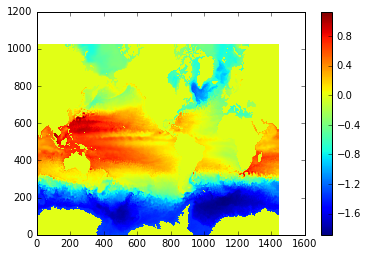

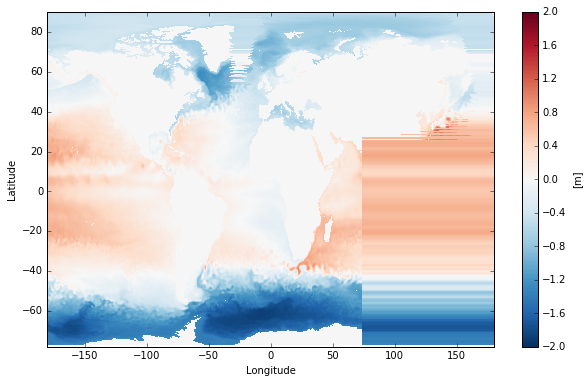

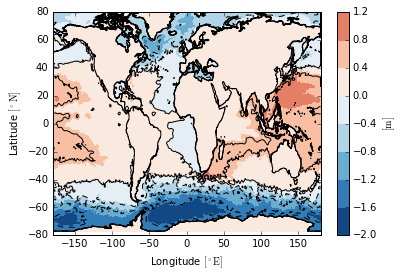

In [6]:
import os, sys, time                      ## import OS, system, and timing controls
import numpy as np                        ## import support for arrays and some statistics
from scipy import stats                   ## import statistics module
import matplotlib.pyplot as plt           ## import plotting tools
import matplotlib.tri as tri              
from mpl_toolkits.basemap import Basemap  ## import map plotting
from netCDF4 import Dataset               ## import netCDF 
import matplotlib                         ## inline plots
%matplotlib inline

## Read grid 
nc = Dataset('/Users/joakim/Downloads/domain/mask.nc','r')
print nc
tmask = nc.variables['tmask']
print tmask
## Now read tmask into memory
tmask = tmask[:,:,:,:]
nc.close()

## Read data
nc = Dataset('/Users/joakim/Downloads/means/2000/ORCA025-N401_20000105d05T.nc','r')
lon = nc.variables['nav_lon'][:,:]
lat = nc.variables['nav_lat'][:,:]
ssh = nc.variables['sossheig'][:,:,:]
nc.close()

## Zero unrealistic values (problem with land suppression in NEMO)
ssh = np.where(ssh > 20,0,ssh)

## Average over time dimension (left-most)
mean_ssh = np.ma.mean(ssh, axis=0)

## Quick plot
plt.pcolormesh(mean_ssh)
plt.colorbar()
plt.show() 

## We can fine tune it a bit
## if we control figure and axes
fig    = plt.figure(figsize=(10,6))  ## 10x6 inches
ax     = fig.add_subplot(111)        ## make a 1x1 subplot grid, this is #1
vmin   = -2.0  # min ssh
vmax   =  2.0  # max ssh
levels = np.arange(vmin,vmax+0.5,0.5) ## array with contour levels
pc     = ax.pcolormesh(lon,lat,mean_ssh,vmin=vmin,vmax=vmax,cmap=plt.cm.RdBu_r)
cb     = plt.colorbar(pc,ax=ax,orientation='vertical')
cb.set_label('[m]')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim([-180,180])
ax.set_ylim([-78,90])

fig    = plt.figure()
ax     = fig.add_subplot(111)
triang = tri.Triangulation(lon.flatten(), lat.flatten())
cf     = ax.tricontourf(triang, mean_ssh.flatten(),vmin=vmin,vmax=vmax,cmap=plt.cm.RdBu_r)
ct     = ax.tricontour(triang,  mean_ssh.flatten(),levels=levels,colors='k')
ct     = ax.tricontour(triang,  tmask[0,0,:,:].flatten(),levels=np.arange(0,3),colors='k')
cb     = plt.colorbar(cf,ax=ax,orientation='vertical')
cb.set_label(r'$[\mathrm{m}]$') ## the r gets us to LaTeX mode!
ax.set_xlim([-180,180])
ax.set_ylim([-80,80])
ax.set_xlabel(r'Longitude $[{}^\circ\mathrm{E}]$')
ax.set_ylabel(r'Latitude $[{}^\circ\mathrm{N}]$')

plt.show()

Let's plot on a map (with the previous work still in memory)

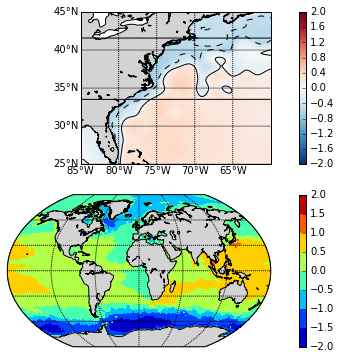

In [7]:
fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,ncols=1) ## two subplots
map1   = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=45,\
                 llcrnrlon=-85,urcrnrlon=-60,resolution='i',ax=ax1)
map1.fillcontinents(color='lightgray')
map1.drawcoastlines()
map1.drawparallels(np.arange( 25, 50,5),labels=[1,0,0,0],fontsize=10)
map1.drawmeridians(np.arange(-85,-60,5),labels=[0,0,0,1],fontsize=10) 

x,y    = map1(lon,lat) ## project lon,lat to map coordinates
pc     = map1.pcolor(x,y,mean_ssh,vmin=vmin,vmax=vmax,cmap=plt.cm.RdBu_r)
cb     = plt.colorbar(pc,ax=ax1)
ct     = map1.contour(x,y,mean_ssh,levels=levels,colors='k')

map2   = Basemap(projection='kav7',lon_0=0,resolution='c')
map2.fillcontinents(color='lightgray')
map2.drawcoastlines()
map2.drawparallels(np.arange( -90, 90, 30))
map2.drawmeridians(np.arange(-180,180, 60))

x,y    = map2(lon,lat)
pc     = map2.contourf(x.flatten(),y.flatten(),mean_ssh.flatten(),levels=levels,tri=True)
cb     = plt.colorbar(pc,ax=ax2)

plt.show()

## Installing python: 

* apt-get/yum (Linux), fink/MacPorts (Mac)
* Enthought Python Distribution (free for academia). 
* Anaconda (distribution for Win, Mac, Linux, etc)

## The OxPUG group: 

https://groups.google.com/forum/#!forum/oxford-python-users

## Resources: 

* matplotlib has an extensive documentation, example scripts, and gallery of plots. http://www.matplotlib.org
* scipy/numpy documentation with details for each function. http://www.scipy.org
* numpy for MATLAB users. http://mathesaurus.sourceforge.net/matlab-numpy.html
* A cookbook with some statistics & plotting examples. http://scipy-cookbook.readthedocs.io/index.html
